In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
movies = pd.read_csv("https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


time: 251 ms (started: 2024-05-09 17:54:17 +00:00)


In [ ]:
!pip install ipython-autotime
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.9 MB/s eta 0:00:00
time: 427 µs (started: 2024-05-09 17:31:10 +00:00)


In [ ]:
ratings = pd.read_csv("https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


time: 325 ms (started: 2024-05-09 17:54:20 +00:00)


<ipython-input-116-c83c7388b031>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='genre', data=data.head(20), palette='viridis')


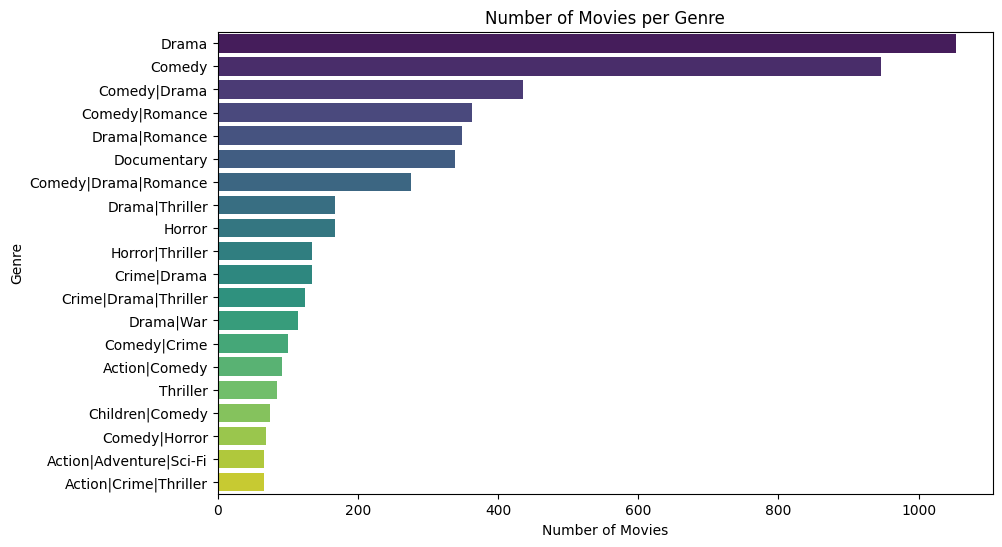

time: 523 ms (started: 2024-05-09 17:54:22 +00:00)


In [ ]:
data=movies['genres'].value_counts()
data=data.reset_index()

data.columns= ['genre', 'count']
data=data.sort_values(by='count', ascending=False)
# Create a bar plot
plt.figure(figsize=(10, 6))  # Set the figure size
sns.barplot(x='count', y='genre', data=data.head(20), palette='viridis')

# Add labels and title
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.title('Number of Movies per Genre')

# Show the plot
plt.show()


## The Recommendation Algorithm
Based on https://www.geeksforgeeks.org/recommendation-system-in-python/

In [ ]:
n_ratings = len(ratings)
n_movies = len(ratings['movieId'].unique())
n_users = len(ratings['userId'].unique())

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610
Average ratings per user: 165.3
Average ratings per movie: 10.37
time: 7.64 ms (started: 2024-05-09 17:54:25 +00:00)


In [ ]:
user_freq = ratings[['userId', 'movieId']].groupby(
    'userId').count().reset_index()
user_freq.columns = ['userId', 'n_ratings']
print(user_freq.head())

   userId  n_ratings
0       1        232
1       2         29
2       3         39
3       4        216
4       5         44
time: 15.9 ms (started: 2024-05-09 17:54:27 +00:00)


In [ ]:
# Find Lowest and Highest rated movies:
from sklearn.neighbors import NearestNeighbors
mean_rating = ratings.groupby('movieId')[['rating']].mean()
# Lowest rated movies
lowest_rated = mean_rating['rating'].idxmin()
movies.loc[movies['movieId'] == lowest_rated]
# Highest rated movies
highest_rated = mean_rating['rating'].idxmax()
movies.loc[movies['movieId'] == highest_rated]
# show number of people who rated movies rated movie highest
ratings[ratings['movieId']==highest_rated]
# show number of people who rated movies rated movie lowest
ratings[ratings['movieId']==lowest_rated]

## the above movies has very low dataset. We will use bayesian average
movie_stats = ratings.groupby('movieId')[['rating']].agg(['count', 'mean'])
movie_stats.columns = movie_stats.columns.droplevel()
# Now, we create user-item matrix using scipy csr matrix
from scipy.sparse import csr_matrix
import numpy as np
def create_matrix(df):

	N = len(df['userId'].unique())
	M = len(df['movieId'].unique())

	# Map Ids to indices
	user_mapper = dict(zip(np.unique(df["userId"]), list(range(N))))
	movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(M))))

	# Map indices to IDs
	user_inv_mapper = dict(zip(list(range(N)), np.unique(df["userId"])))
	movie_inv_mapper = dict(zip(list(range(M)), np.unique(df["movieId"])))

	user_index = [user_mapper[i] for i in df['userId']]
	movie_index = [movie_mapper[i] for i in df['movieId']]

	X = csr_matrix((df["rating"], (movie_index, user_index)), shape=(M, N))

	return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_matrix(ratings)
"""
Find similar movies using KNN
"""
def find_similar_movies(movie_id, X, k, metric='euclidean', show_distance=False):

	neighbour_ids = []

	movie_ind = movie_mapper[movie_id]
	movie_vec = X[movie_ind]
	k+=1
	kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
	kNN.fit(X)
	movie_vec = movie_vec.reshape(1,-1)
	neighbour = kNN.kneighbors(movie_vec, return_distance=show_distance)
	for i in range(0,k):
		n = neighbour.item(i)
		neighbour_ids.append(movie_inv_mapper[n])
	neighbour_ids.pop(0)
	return neighbour_ids


movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 3

similar_ids = find_similar_movies(movie_id, X, k=10)
movie_title = movie_titles[movie_id]

print(f"Since you watched {movie_title}, {movie_id}")
for i in similar_ids:
	print(movie_titles[i])


Since you watched Grumpier Old Men (1995), 3
Son in Law (1993)
Striptease (1996)
Juror, The (1996)
Flipper (1996)
Beverly Hillbillies, The (1993)
Bio-Dome (1996)
Kazaam (1996)
Angus (1995)
Tales from the Crypt Presents: Bordello of Blood (1996)
Substitute, The (1996)
time: 121 ms (started: 2024-05-09 17:54:29 +00:00)


In [ ]:
def recommend_movies_for_user(user_id, X, user_mapper, movie_mapper, movie_inv_mapper, k=10):
    df1 = ratings[ratings['userId'] == user_id]

    if df1.empty:
        print(f"User with ID {user_id} does not exist.")
        return []

    # Find the movie with the highest rating by the user
    max_rating_movie = df1.loc[df1['rating'].idxmax(), 'movieId']
    movie_titles = dict(zip(movies['movieId'], movies['title']))

    # Find similar movies to the highest-rated movie
    similar_ids = find_similar_movies(max_rating_movie, X, k)
    recommended_movies = []
    recommended_id= []
    # Collect titles of recommended movies
    for movie_id in similar_ids:
        movie_title = movie_titles.get(movie_id, "Movie not found")
        if movie_title != "Movie not found":
            recommended_movies.append(movie_title)
            recommended_id.append(movie_id)
    return recommended_movies, max_rating_movie, recommended_id

# Example usage:
user_id = 8 # Replace with the desired user ID
recommended_movies, top_movie, recommended_id= recommend_movies_for_user(user_id, X, user_mapper, movie_mapper, movie_inv_mapper, k=10)

if recommended_movies:
    print(f"Recommended movies for user {user_id} since they like {movies.loc[movies['movieId'] == top_movie]['title'].values[0]}:")
    for movie in recommended_movies:
        print(movie)
else:
    print(f"No recommendations found for user {user_id}.")


Recommended movies for user 8 since they like Babe (1995):
Casper (1995)
Honey, I Shrunk the Kids (1989)
Coneheads (1993)
Antz (1998)
Babe: Pig in the City (1998)
Cliffhanger (1993)
Dave (1993)
Aristocats, The (1970)
Flintstones, The (1994)
Indian in the Cupboard, The (1995)
time: 44.5 ms (started: 2024-05-09 17:54:38 +00:00)


,movieId,title,genres
6801,60756,Step Brothers (2008),Comedy


In [ ]:
user_df=ratings[ratings['userId']==8]
user_df[user_df['movieId'].isin(recommended_id)]

,userId,movieId,rating,timestamp
1060,8,440,3.0,839463728


time: 18.3 ms (started: 2024-05-09 17:54:43 +00:00)


## Evaluation Metric : Evaluating the current Algorithm

In [ ]:
import pandas as pd


users = ratings['userId'].unique().tolist()
user_use = []
evaluation_scores = []

for user_id in users:
    recommended_movies, top_movie, recommended_id= recommend_movies_for_user(user_id,  X, user_mapper, movie_mapper, movie_inv_mapper, k=10)
    user_df = ratings[ratings['userId'] == user_id]
    seen_movies_ratings = user_df[user_df['movieId'].isin(recommended_id)]['rating'].tolist()

    if seen_movies_ratings:  # Check if seen_movies_ratings is not empty
        above_threshold_count = sum(1 for value in seen_movies_ratings if value > 3)
        total_values_count = len(seen_movies_ratings)

        if total_values_count > 0:
            evaluation_score = above_threshold_count / total_values_count
            user_use.append(user_id)
            evaluation_scores.append(evaluation_score)




time: 31.6 s (started: 2024-05-09 17:32:12 +00:00)


In [ ]:
np.mean(evaluation_scores)

0.7547314448167326

time: 7.3 ms (started: 2024-05-09 17:32:44 +00:00)


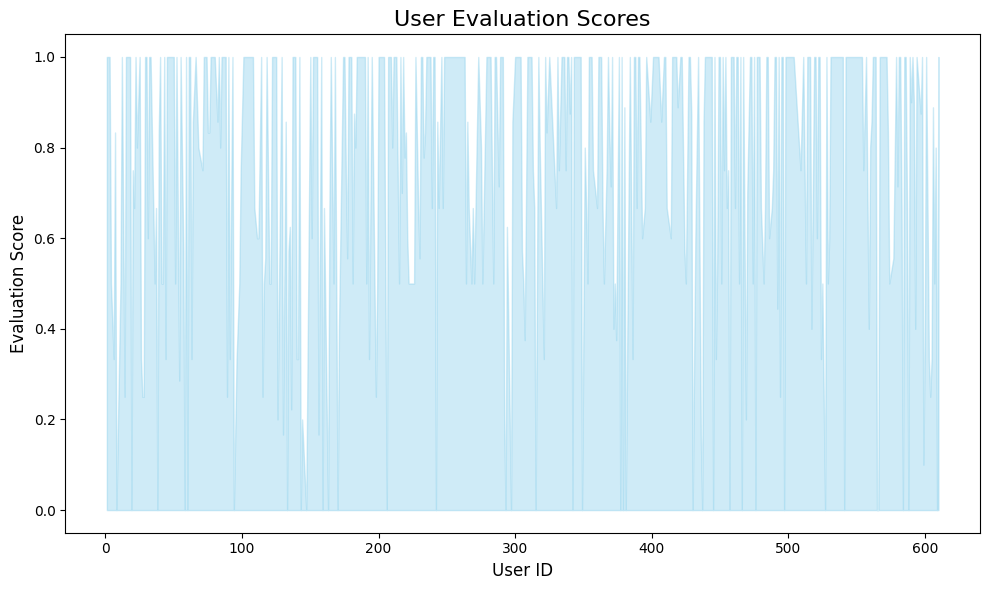

time: 364 ms (started: 2024-05-09 17:32:44 +00:00)


In [ ]:
import matplotlib.pyplot as plt

# Sample data (replace with your actual data)


# Plotting the area chart
plt.figure(figsize=(10, 6))  # Set the figure size (width, height)

# Plotting the area chart
plt.fill_between(user_use, evaluation_scores, color='skyblue', alpha=0.4)  # Fill area under the line

# Plot customization
plt.title('User Evaluation Scores', fontsize=16)  # Set the plot title
plt.xlabel('User ID', fontsize=12)  # Set the label for x-axis
plt.ylabel('Evaluation Score', fontsize=12)  # Set the label for y-axis



# Display the plot
plt.tight_layout()  # Adjust layout to prevent overlap of labels
plt.show()


###Experiment 1: Evaluating the metric, how does it change with different number of clusters?

In [ ]:
EVAL=[]

for i in range(1,40):
  user_use = []
  evaluation_scores = []
  for user_id in users:
    recommended_movies, top_movie, recommended_id= recommend_movies_for_user(user_id, X, user_mapper, movie_mapper, movie_inv_mapper, k=i)
    user_df = ratings[ratings['userId'] == user_id]
    seen_movies_ratings = user_df[user_df['movieId'].isin(recommended_id)]['rating'].tolist()

    if seen_movies_ratings:  # Check if seen_movies_ratings is not empty
        above_threshold_count = sum(1 for value in seen_movies_ratings if value > 3)
        total_values_count = len(seen_movies_ratings)

        if total_values_count > 0:
            evaluation_score = above_threshold_count / total_values_count
            user_use.append(user_id)
            evaluation_scores.append(evaluation_score)
  print(i,np.mean(evaluation_scores))
  EVAL.append((i,np.mean(evaluation_scores)))



1 0.8242677824267782
2 0.7795031055900621
3 0.7899353647276085
4 0.80306905370844
5 0.7914436334144362
6 0.783138629283489
7 0.76892455858748
8 0.7623971032614358
9 0.75558991273277
10 0.7547314448167326
11 0.7455898455898456
12 0.7467375103177571
13 0.7429358566603466
14 0.7422864942134719
15 0.741089289196859
16 0.7392042306089458
17 0.738638396601933
18 0.736006638208254
19 0.7356228929445165
20 0.7305561156035227
21 0.7282101354203391
22 0.7274145617926636
23 0.7269640333741827
24 0.7251215305226708
25 0.7215273823730293
26 0.7204366723564787
27 0.721862311222198
28 0.720425293580474
29 0.7224211149014654
30 0.719964875649513
31 0.7195815313517908
32 0.7181766070238998
33 0.7195591777440286
34 0.7196209781663991
35 0.7215815711264971
36 0.7166375288140551
37 0.7176360799000747
38 0.7173713956039157
39 0.7155353862529759
time: 16min 17s (started: 2024-05-09 17:54:48 +00:00)


Text(0.5, 0, 'Number of Clusters')

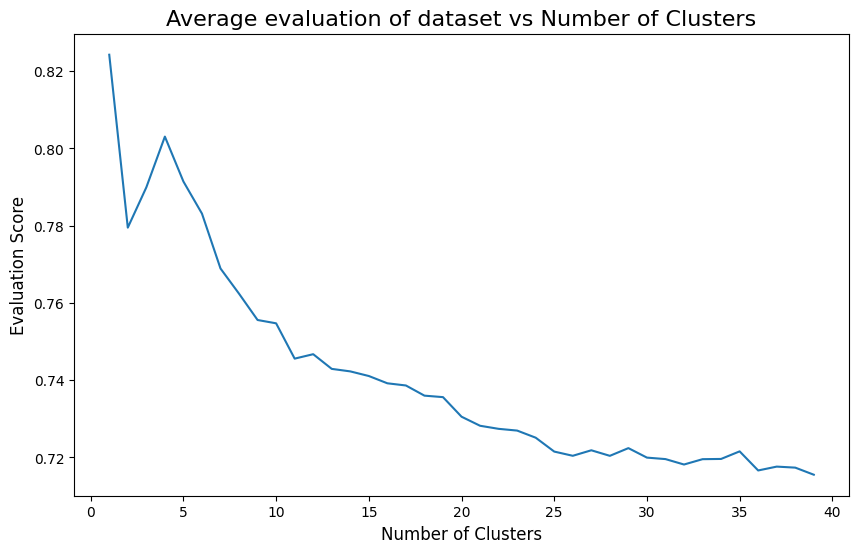

time: 413 ms (started: 2024-05-09 18:14:20 +00:00)


In [ ]:
# Change plt.label to plt.ylabel
plt.figure(figsize=(10, 6))  # Set the figure size (width, height)
plt.plot(list(zip(*EVAL))[0],list(zip(*EVAL))[1])
plt.ylabel('Evaluation Score', fontsize=12)  # Set the label for y-axis
plt.title('Average evaluation of dataset vs Number of Clusters', fontsize=16)  # Set the plot title
plt.xlabel('Number of Clusters', fontsize=12)  # Set the label for x-axis

##Experiment 2: Testing with different sizes of data

###Experiment 2a: Only using 10% of the data (reducing to only work with 50% of the total movies)

In [ ]:
import random
#Sampling to use only 10% of the movies
movie_ids = ratings['movieId'].unique().tolist()
sample_size = int(len(movie_ids) * 0.1)
movies_to_use = random.sample(movie_ids, sample_size)
movies=movies[movies['movieId'].isin(movies_to_use)]
ratings=ratings[ratings['movieId'].isin(movies_to_use)]
ratings.head()

,userId,movieId,rating,timestamp
15,1,260,5.0,964981680
34,1,593,4.0,964983793
47,1,943,4.0,964983614
53,1,1029,5.0,964982855
56,1,1032,5.0,964982791


time: 32.6 ms (started: 2024-05-09 17:32:45 +00:00)


In [ ]:
#Recreating the user-movie matrix
mean_rating = ratings.groupby('movieId')[['rating']].mean()
# Lowest rated movies
lowest_rated = mean_rating['rating'].idxmin()
movies.loc[movies['movieId'] == lowest_rated]
# Highest rated movies
highest_rated = mean_rating['rating'].idxmax()
movies.loc[movies['movieId'] == highest_rated]
# show number of people who rated movies rated movie highest
ratings[ratings['movieId']==highest_rated]
# show number of people who rated movies rated movie lowest
ratings[ratings['movieId']==lowest_rated]

## the above movies has very low dataset. We will use bayesian average
movie_stats = ratings.groupby('movieId')[['rating']].agg(['count', 'mean'])
movie_stats.columns = movie_stats.columns.droplevel()
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_matrix(ratings)

time: 26.3 ms (started: 2024-05-09 17:32:45 +00:00)


In [ ]:
##running on sample user
user_id = 3
recommended_movies, top_movie, recommended_id= recommend_movies_for_user(user_id,  X, user_mapper, movie_mapper, movie_inv_mapper, k=5)
if recommended_movies:
    print(f"Recommended movies for user {user_id} since they like {movies.loc[movies['movieId'] == top_movie]['title'].values[0]}:")
    for movie in recommended_movies:
        print(movie)
else:
    print(f"No recommendations found for user {user_id}.")


Recommended movies for user 3 since they like Saturn 3 (1980):
Meteor (1979)
Night to Remember, A (1958)
Android (1982)
Air Bud: Golden Receiver (1998)
Gone Fishin' (1997)
time: 8.72 ms (started: 2024-05-09 17:32:45 +00:00)


####Testing on Evaluation Metric

In [ ]:
import pandas as pd

users = ratings['userId'].unique().tolist()
user_use = []
evaluation_scores = []

for user_id in users:
    recommended_movies, top_movie, recommended_id= recommend_movies_for_user(user_id,  X, user_mapper, movie_mapper, movie_inv_mapper, k=5)
    user_df = ratings[ratings['userId'] == user_id]
    seen_movies_ratings = user_df[user_df['movieId'].isin(recommended_id)]['rating'].tolist()

    if seen_movies_ratings:  # Check if seen_movies_ratings is not empty
        above_threshold_count = sum(1 for value in seen_movies_ratings if value > 3)
        total_values_count = len(seen_movies_ratings)

        if total_values_count > 0:
            evaluation_score = above_threshold_count / total_values_count
            user_use.append(user_id)
            evaluation_scores.append(evaluation_score)

time: 9.09 s (started: 2024-05-09 17:33:02 +00:00)


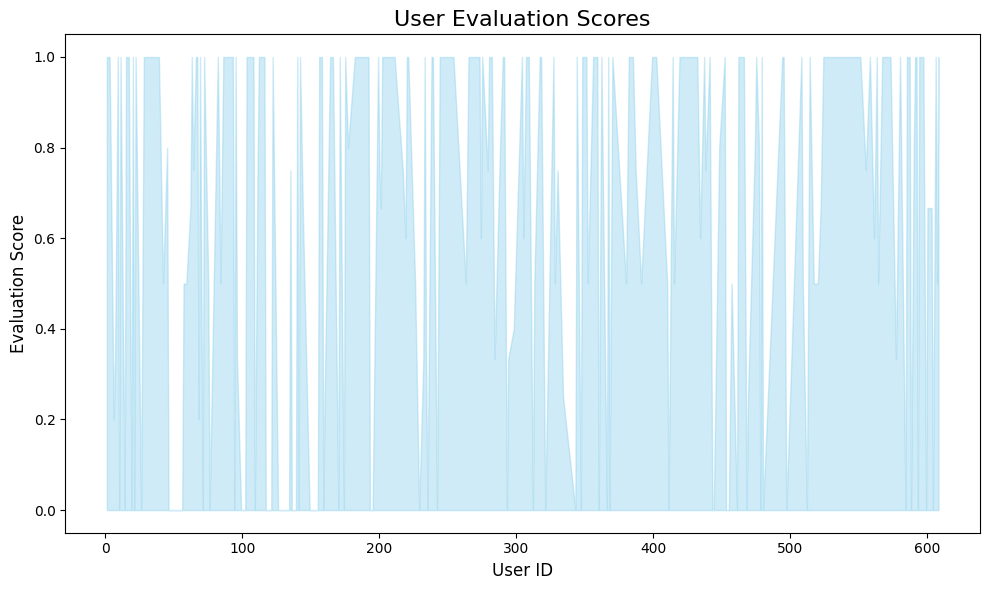

time: 347 ms (started: 2024-05-09 17:33:11 +00:00)


In [ ]:
import matplotlib.pyplot as plt

# Sample data (replace with your actual data)


# Plotting the area chart
plt.figure(figsize=(10, 6))  # Set the figure size (width, height)

# Plotting the area chart
plt.fill_between(user_use, evaluation_scores, color='skyblue', alpha=0.4)  # Fill area under the line

# Plot customization
plt.title('User Evaluation Scores', fontsize=16)  # Set the plot title
plt.xlabel('User ID', fontsize=12)  # Set the label for x-axis
plt.ylabel('Evaluation Score', fontsize=12)  # Set the label for y-axis



# Display the plot
plt.tight_layout()  # Adjust layout to prevent overlap of labels
plt.show()

In [ ]:
np.mean(evaluation_scores)

0.6554018445322793

time: 4.29 ms (started: 2024-05-09 17:33:12 +00:00)


###Experiment 2b: Filtering to only use the top 50 highest average voted movies.


In [ ]:
#Filterning to only keep top 50 movies
movies = pd.read_csv("https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv")
ratings = pd.read_csv("https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv")
total_rating_per_movie = ratings.groupby('movieId')['rating'].agg(['mean', 'count']).reset_index()
total_rating_per_movie.columns = ['movieId', 'rating_average', 'rating_count']
total_rating_per_movie = total_rating_per_movie[total_rating_per_movie['rating_count']>=20]
#to use movies that were rated by at least 20 users to get meaningful results
#you can experiment with this number as well to see different results
total_rating_per_movie.sort_values(by='rating_average', ascending=False, inplace=True)
top_50_movies = total_rating_per_movie.head(50)
top_50_movies_ids = top_50_movies['movieId'].tolist()
ratings = ratings[ratings['movieId'].isin(top_50_movies_ids)]
movies = movies[movies['movieId'].isin(top_50_movies_ids)]
ratings

,userId,movieId,rating,timestamp
4,1,50,5.0,964982931
15,1,260,5.0,964981680
16,1,296,3.0,964982967
28,1,527,5.0,964984002
62,1,1089,5.0,964982951
...,...,...,...,...
99699,610,2959,5.0,1479541966
99871,610,4973,4.0,1479543012
100217,610,48516,5.0,1479542152
100310,610,58559,4.5,1493844688


time: 493 ms (started: 2024-05-09 19:22:36 +00:00)


In [ ]:
#creating matrix again
#Recreating the user-movie matrix
mean_rating = ratings.groupby('movieId')[['rating']].mean()
# Lowest rated movies
lowest_rated = mean_rating['rating'].idxmin()
movies.loc[movies['movieId'] == lowest_rated]
# Highest rated movies
highest_rated = mean_rating['rating'].idxmax()
movies.loc[movies['movieId'] == highest_rated]
# show number of people who rated movies rated movie highest
ratings[ratings['movieId']==highest_rated]
# show number of people who rated movies rated movie lowest
ratings[ratings['movieId']==lowest_rated]

## the above movies has very low dataset. We will use bayesian average
movie_stats = ratings.groupby('movieId')[['rating']].agg(['count', 'mean'])
movie_stats.columns = movie_stats.columns.droplevel()
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_matrix(ratings)


time: 20.6 ms (started: 2024-05-09 17:33:14 +00:00)


In [ ]:
# testing on sample user
user_id=1
recommended_movies, top_movie, recommended_id= recommend_movies_for_user(user_id,  X, user_mapper, movie_mapper, movie_inv_mapper, k=10)
if recommended_movies:
    print(f"Recommended movies for user {user_id} since they like {movies.loc[movies['movieId'] == top_movie]['title'].values[0]}:")
    for movie in recommended_movies:
        print(movie)
else:
    print(f"No recommendations found for user {user_id}.")


Recommended movies for user 1 since they like Usual Suspects, The (1995):
Reservoir Dogs (1992)
Goodfellas (1990)
Godfather: Part II, The (1974)
American History X (1998)
Apocalypse Now (1979)
Departed, The (2006)
Godfather, The (1972)
Pulp Fiction (1994)
Boondock Saints, The (2000)
One Flew Over the Cuckoo's Nest (1975)
time: 81.5 ms (started: 2024-05-09 17:33:16 +00:00)


####Evaluating on the Evaluation Metric

In [ ]:
import pandas as pd



users = ratings['userId'].unique().tolist()
user_use = []
evaluation_scores = []

for user_id in users:
    recommended_movies, top_movie, recommended_id= recommend_movies_for_user(user_id,  X, user_mapper, movie_mapper, movie_inv_mapper, k=10)
    user_df = ratings[ratings['userId'] == user_id]
    seen_movies_ratings = user_df[user_df['movieId'].isin(recommended_id)]['rating'].tolist()

    if seen_movies_ratings:  # Check if seen_movies_ratings is not empty
        above_threshold_count = sum(1 for value in seen_movies_ratings if value > 3)
        total_values_count = len(seen_movies_ratings)

        if total_values_count > 0:
            evaluation_score = above_threshold_count / total_values_count
            user_use.append(user_id)
            evaluation_scores.append(evaluation_score)

time: 6.17 s (started: 2024-05-09 17:33:31 +00:00)


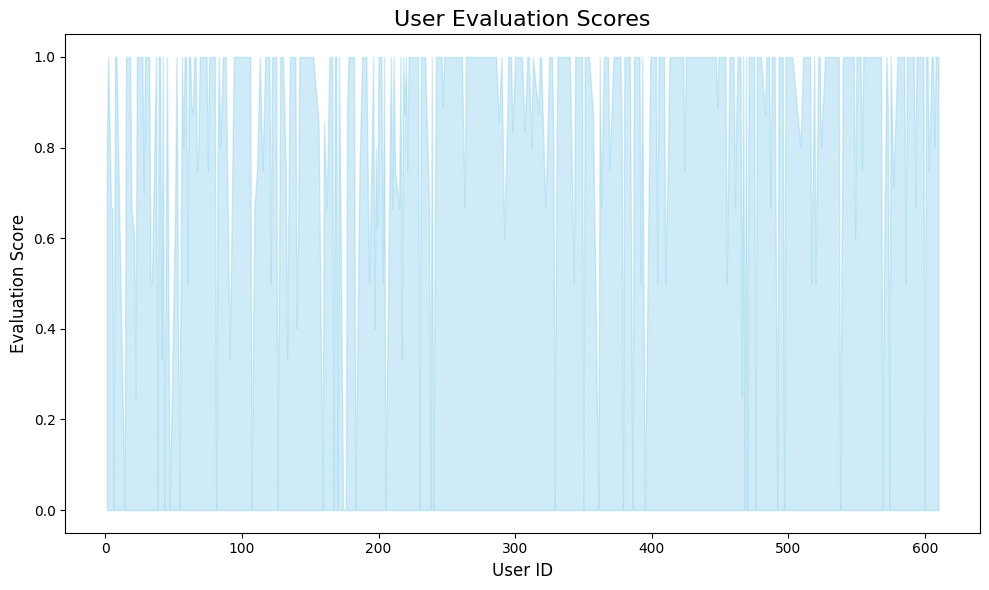

time: 339 ms (started: 2024-05-09 17:33:38 +00:00)


In [ ]:
import matplotlib.pyplot as plt

# Sample data (replace with your actual data)


# Plotting the area chart
plt.figure(figsize=(10, 6))  # Set the figure size (width, height)

# Plotting the area chart
plt.fill_between(user_use, evaluation_scores, color='skyblue', alpha=0.4)  # Fill area under the line

# Plot customization
plt.title('User Evaluation Scores', fontsize=16)  # Set the plot title
plt.xlabel('User ID', fontsize=12)  # Set the label for x-axis
plt.ylabel('Evaluation Score', fontsize=12)  # Set the label for y-axis



# Display the plot
plt.tight_layout()  # Adjust layout to prevent overlap of labels
plt.show()

In [ ]:
np.mean(evaluation_scores)

0.8491211122476039

time: 5.79 ms (started: 2024-05-09 17:33:38 +00:00)


###Experiment 2c: Filtering to keep the top 50 highest average rated movies per user

In [ ]:
movies=pd.read_csv("https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv")
ratings=pd.read_csv("https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv")
user_filter_per_user = ratings.groupby('userId').apply  (lambda x: x.sort_values(by='rating', ascending=False).head(50))

ratings=user_filter_per_user.reset_index(drop=True)
movies=movies[movies['movieId'].isin(ratings['movieId'])]
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


time: 902 ms (started: 2024-05-09 17:33:51 +00:00)


In [ ]:
#creating matrix again
#Recreating the user-movie matrix
mean_rating = ratings.groupby('movieId')[['rating']].mean()
# Lowest rated movies
lowest_rated = mean_rating['rating'].idxmin()
movies.loc[movies['movieId'] == lowest_rated]
# Highest rated movies
highest_rated = mean_rating['rating'].idxmax()
movies.loc[movies['movieId'] == highest_rated]
# show number of people who rated movies rated movie highest
ratings[ratings['movieId']==highest_rated]
# show number of people who rated movies rated movie lowest
ratings[ratings['movieId']==lowest_rated]

## the above movies has very low dataset. We will use bayesian average
movie_stats = ratings.groupby('movieId')[['rating']].agg(['count', 'mean'])
movie_stats.columns = movie_stats.columns.droplevel()
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_matrix(ratings)


time: 39.1 ms (started: 2024-05-09 17:33:53 +00:00)


In [ ]:
# testing on sample user
user_id=1
recommended_movies, top_movie, recommended_id= recommend_movies_for_user(user_id,  X, user_mapper, movie_mapper, movie_inv_mapper, k=10)
if recommended_movies:
    print(f"Recommended movies for user {user_id} since they like {movies.loc[movies['movieId'] == top_movie]['title'].values[0]}:")
    for movie in recommended_movies:
        print(movie)
else:
    print(f"No recommendations found for user {user_id}.")


Recommended movies for user 1 since they like M*A*S*H (a.k.a. MASH) (1970):
South Pacific (1958)
Cape Fear (1962)
Suspicion (1941)
Born Yesterday (1950)
Quiet Man, The (1952)
Gulliver's Travels (1939)
Howard the Duck (1986)
Stand and Deliver (1988)
Sullivan's Travels (1941)
Shop Around the Corner, The (1940)
time: 12.3 ms (started: 2024-05-09 17:33:56 +00:00)


In [ ]:
import pandas as pd
users = ratings['userId'].unique().tolist()
user_use = []
evaluation_scores = []

for user_id in users:
    recommended_movies, top_movie, recommended_id= recommend_movies_for_user(user_id,  X, user_mapper, movie_mapper, movie_inv_mapper, k=10)
    user_df = ratings[ratings['userId'] == user_id]
    seen_movies_ratings = user_df[user_df['movieId'].isin(recommended_id)]['rating'].tolist()

    if seen_movies_ratings:  # Check if seen_movies_ratings is not empty
        above_threshold_count = sum(1 for value in seen_movies_ratings if value > 3)
        total_values_count = len(seen_movies_ratings)

        if total_values_count > 0:
            evaluation_score = above_threshold_count / total_values_count
            user_use.append(user_id)
            evaluation_scores.append(evaluation_score)


time: 11.2 s (started: 2024-05-09 17:34:14 +00:00)


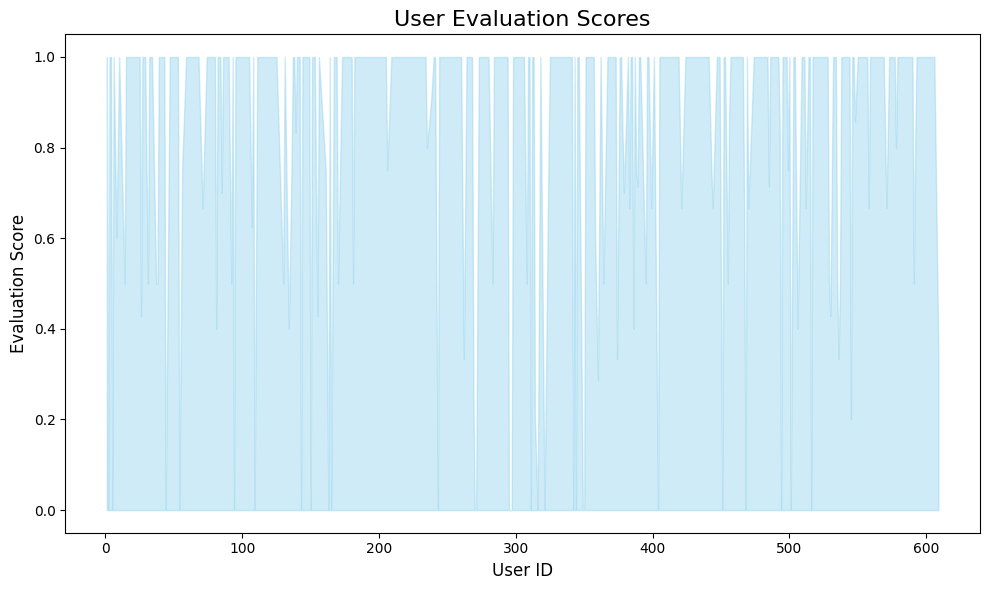

time: 347 ms (started: 2024-05-09 17:34:25 +00:00)


In [ ]:
import matplotlib.pyplot as plt

# Sample data (replace with your actual data)


# Plotting the area chart
plt.figure(figsize=(10, 6))  # Set the figure size (width, height)

# Plotting the area chart
plt.fill_between(user_use, evaluation_scores, color='skyblue', alpha=0.4)  # Fill area under the line

plt.title('User Evaluation Scores', fontsize=16)  # Set the plot title
plt.xlabel('User ID', fontsize=12)  # Set the label for x-axis
plt.ylabel('Evaluation Score', fontsize=12)  # Set the label for y-axis

plt.tight_layout()
plt.show()

In [ ]:
np.mean(evaluation_scores)

0.8545287187039765

time: 7.31 ms (started: 2024-05-09 17:34:26 +00:00)


##Experiment 3: Combining the two approaches

###Experiment 3a: Testing for different numbers of clusters with filtering to keep only the top 50 highest average voted movies.

In [ ]:
#Filterning to only keep top 50 movies
movies = pd.read_csv("https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv")
ratings = pd.read_csv("https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv")
total_rating_per_movie = ratings.groupby('movieId')['rating'].agg(['mean', 'count']).reset_index()
total_rating_per_movie.columns = ['movieId', 'rating_average', 'rating_count']
total_rating_per_movie = total_rating_per_movie[total_rating_per_movie['rating_count']>=20]
#to use movies that were rated by at least 20 users to get meaningful results
#you can experiment with this number as well to see different results
total_rating_per_movie.sort_values(by='rating_average', ascending=False, inplace=True)
top_50_movies = total_rating_per_movie.head(50)
top_50_movies_ids = top_50_movies['movieId'].tolist()
ratings = ratings[ratings['movieId'].isin(top_50_movies_ids)]
movies = movies[movies['movieId'].isin(top_50_movies_ids)]
ratings

,userId,movieId,rating,timestamp
4,1,50,5.0,964982931
15,1,260,5.0,964981680
16,1,296,3.0,964982967
28,1,527,5.0,964984002
62,1,1089,5.0,964982951
...,...,...,...,...
99699,610,2959,5.0,1479541966
99871,610,4973,4.0,1479543012
100217,610,48516,5.0,1479542152
100310,610,58559,4.5,1493844688


time: 413 ms (started: 2024-05-09 19:23:18 +00:00)


In [ ]:
#creating matrix again
#Recreating the user-movie matrix
mean_rating = ratings.groupby('movieId')[['rating']].mean()
# Lowest rated movies
lowest_rated = mean_rating['rating'].idxmin()
movies.loc[movies['movieId'] == lowest_rated]
# Highest rated movies
highest_rated = mean_rating['rating'].idxmax()
movies.loc[movies['movieId'] == highest_rated]
# show number of people who rated movies rated movie highest
ratings[ratings['movieId']==highest_rated]
# show number of people who rated movies rated movie lowest
ratings[ratings['movieId']==lowest_rated]

## the above movies has very low dataset. We will use bayesian average
movie_stats = ratings.groupby('movieId')[['rating']].agg(['count', 'mean'])
movie_stats.columns = movie_stats.columns.droplevel()
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_matrix(ratings)


time: 28.9 ms (started: 2024-05-09 19:23:43 +00:00)


In [ ]:
EVAL=[]

users = ratings['userId'].unique().tolist()
for i in range(1,40):
  user_use = []
  evaluation_scores = []
  for user_id in users:
    recommended_movies, top_movie, recommended_id= recommend_movies_for_user(user_id, X, user_mapper, movie_mapper, movie_inv_mapper, k=i)
    user_df = ratings[ratings['userId'] == user_id]
    seen_movies_ratings = user_df[user_df['movieId'].isin(recommended_id)]['rating'].tolist()

    if seen_movies_ratings:  # Check if seen_movies_ratings is not empty
        above_threshold_count = sum(1 for value in seen_movies_ratings if value > 3)
        total_values_count = len(seen_movies_ratings)

        if total_values_count > 0:
            evaluation_score = above_threshold_count / total_values_count
            user_use.append(user_id)
            evaluation_scores.append(evaluation_score)
  print(i,np.mean(evaluation_scores))
  EVAL.append((i,np.mean(evaluation_scores)))

1 0.8471615720524017
2 0.8525423728813559
3 0.8477611940298507
4 0.8482905982905983
5 0.8481981981981983
6 0.8457890070921985
7 0.849040139616056
8 0.8544524988213107
9 0.8502616747181965
10 0.8491211122476039
11 0.8518978717438433
12 0.84777103588579
13 0.8465866172159879
14 0.8404175836934457
15 0.8329914782187509
16 0.8335539366365158
17 0.8327664651588853
18 0.8333184383717348
19 0.8295732417034829
20 0.8276231042843656
21 0.8261772411839022
22 0.8264132927608298
23 0.8274478535806525
24 0.8249422692049523
25 0.8262139046686584
26 0.8274624075766795
27 0.8283325805519701
28 0.8261983086452775
29 0.8263004997304358
30 0.8268165893766235
31 0.8287413113168658
32 0.8295927455794109
33 0.8275780375812742
34 0.8288018816317118
35 0.8295416492569302
36 0.8285217292924223
37 0.8292391122698162
38 0.8274301295558445
39 0.8269565361189227
time: 3min 15s (started: 2024-05-09 19:23:59 +00:00)


Text(0.5, 0, 'Number of Clusters')

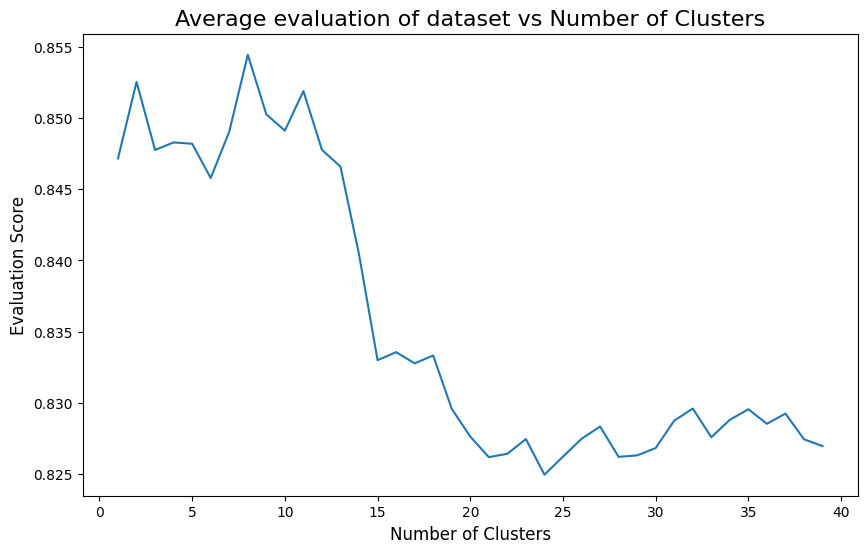

time: 309 ms (started: 2024-05-09 19:27:14 +00:00)


In [ ]:
plt.figure(figsize=(10, 6))  # Set the figure size (width, height)
plt.plot(list(zip(*EVAL))[0],list(zip(*EVAL))[1])
plt.ylabel('Evaluation Score', fontsize=12)  # Set the label for y-axis
plt.title('Average evaluation of dataset vs Number of Clusters', fontsize=16)  # Set the plot title
plt.xlabel('Number of Clusters', fontsize=12)  # Set the label for x-axis

In [ ]:
max_index = max(range(len(EVAL)), key=lambda i: EVAL[i][1])
max_index

(8, 0.8544524988213107)

time: 12.8 ms (started: 2024-05-09 19:31:26 +00:00)


#### Using 8 Clusters to see the distribution over users.

In [ ]:

users = ratings['userId'].unique().tolist()
user_use = []
evaluation_scores = []

for user_id in users:
    recommended_movies, top_movie, recommended_id= recommend_movies_for_user(user_id,  X, user_mapper, movie_mapper, movie_inv_mapper, k=8)
    user_df = ratings[ratings['userId'] == user_id]
    seen_movies_ratings = user_df[user_df['movieId'].isin(recommended_id)]['rating'].tolist()

    if seen_movies_ratings:  # Check if seen_movies_ratings is not empty
        above_threshold_count = sum(1 for value in seen_movies_ratings if value > 3)
        total_values_count = len(seen_movies_ratings)

        if total_values_count > 0:
            evaluation_score = above_threshold_count / total_values_count
            user_use.append(user_id)
            evaluation_scores.append(evaluation_score)

time: 5.48 s (started: 2024-05-09 19:31:42 +00:00)


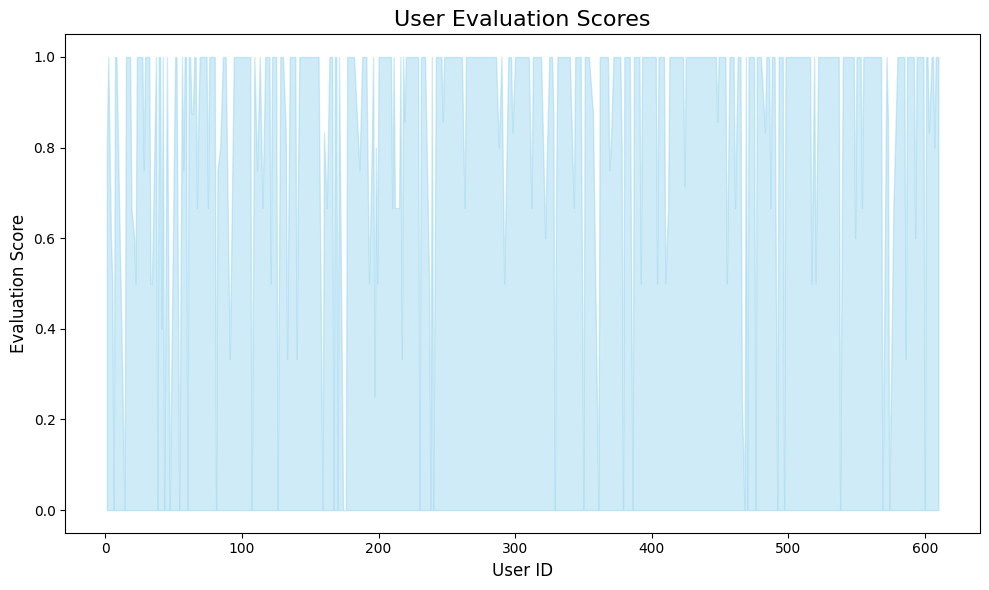

time: 356 ms (started: 2024-05-09 19:31:48 +00:00)


In [ ]:
import matplotlib.pyplot as plt

# Sample data (replace with your actual data)


# Plotting the area chart
plt.figure(figsize=(10, 6))  # Set the figure size (width, height)

# Plotting the area chart
plt.fill_between(user_use, evaluation_scores, color='skyblue', alpha=0.4)  # Fill area under the line

plt.title('User Evaluation Scores', fontsize=16)  # Set the plot title
plt.xlabel('User ID', fontsize=12)  # Set the label for x-axis
plt.ylabel('Evaluation Score', fontsize=12)  # Set the label for y-axis

plt.tight_layout()
plt.show()

In [ ]:
np.mean(evaluation_scores)

0.8544524988213107

time: 3.83 ms (started: 2024-05-09 19:31:51 +00:00)


###Experiment 3b: Combining the Number of Clusters Approach with the approach of keeping the top 50 movies per user

In [ ]:
#Appropriate Filtering
movies=pd.read_csv("https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv")
ratings=pd.read_csv("https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv")
user_filter_per_user = ratings.groupby('userId').apply  (lambda x: x.sort_values(by='rating', ascending=False).head(50))

ratings=user_filter_per_user.reset_index(drop=True)
movies=movies[movies['movieId'].isin(ratings['movieId'])]
ratings[ratings['userId']==1].shape

(50, 4)

time: 923 ms (started: 2024-05-09 19:32:06 +00:00)


In [ ]:
#creating matrix again
#Recreating the user-movie matrix
mean_rating = ratings.groupby('movieId')[['rating']].mean()
# Lowest rated movies
lowest_rated = mean_rating['rating'].idxmin()
movies.loc[movies['movieId'] == lowest_rated]
# Highest rated movies
highest_rated = mean_rating['rating'].idxmax()
movies.loc[movies['movieId'] == highest_rated]
# show number of people who rated movies rated movie highest
ratings[ratings['movieId']==highest_rated]
# show number of people who rated movies rated movie lowest
ratings[ratings['movieId']==lowest_rated]

## the above movies has very low dataset. We will use bayesian average
movie_stats = ratings.groupby('movieId')[['rating']].agg(['count', 'mean'])
movie_stats.columns = movie_stats.columns.droplevel()
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_matrix(ratings)


time: 40.5 ms (started: 2024-05-09 19:32:07 +00:00)


In [ ]:
EVAL=[]

users = ratings['userId'].unique().tolist()
for i in range(1,40):
  user_use = []
  evaluation_scores = []
  for user_id in users:
    recommended_movies, top_movie, recommended_id= recommend_movies_for_user(user_id, X, user_mapper, movie_mapper, movie_inv_mapper, k=i)
    user_df = ratings[ratings['userId'] == user_id]
    seen_movies_ratings = user_df[user_df['movieId'].isin(recommended_id)]['rating'].tolist()

    if seen_movies_ratings:  # Check if seen_movies_ratings is not empty
        above_threshold_count = sum(1 for value in seen_movies_ratings if value > 3)
        total_values_count = len(seen_movies_ratings)

        if total_values_count > 0:
            evaluation_score = above_threshold_count / total_values_count
            user_use.append(user_id)
            evaluation_scores.append(evaluation_score)
  print(i,np.mean(evaluation_scores))
  EVAL.append((i,np.mean(evaluation_scores)))

1 0.8842105263157894
2 0.8614457831325302
3 0.8572261072261071
4 0.8558917197452229
5 0.8609109109109108
6 0.8593542260208926
7 0.8568812140240712
8 0.8570884536610343
9 0.8541244844394451
10 0.8545287187039765
11 0.8531926406926408
12 0.8467683458284962
13 0.8447181524488259
14 0.8444600976154374
15 0.8416998451669986
16 0.8416637039825444
17 0.8406985814503714
18 0.8403690095320665
19 0.840210360183243
20 0.8397170261217978
21 0.8403484628879117
22 0.8412412199024776
23 0.8413995340768105
24 0.8431130763407354
25 0.8360859858145685
26 0.83130403693123
27 0.8304605943879652
28 0.8295811456759169
29 0.8296575482469946
31 0.8244087992038556
32 0.8222554256930019
33 0.8240140556415858
34 0.8241059110445874
35 0.821355063881623
36 0.8216883989122588
37 0.824027635339606
38 0.8233508784730964
39 0.8212795388243102
time: 4min 18s (started: 2024-05-09 19:32:10 +00:00)


Text(0.5, 0, 'Number of Clusters')

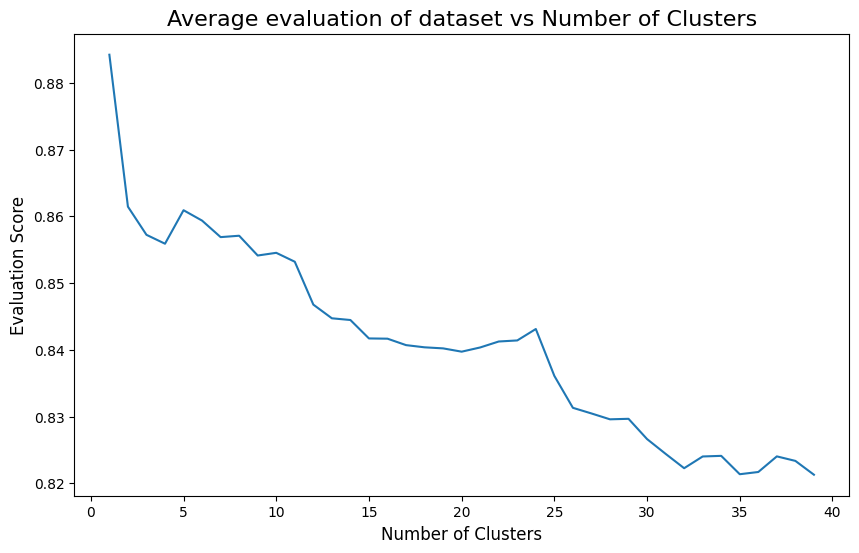

time: 523 ms (started: 2024-05-09 19:36:29 +00:00)


In [ ]:
plt.figure(figsize=(10, 6))  # Set the figure size (width, height)
plt.plot(list(zip(*EVAL))[0],list(zip(*EVAL))[1])
plt.ylabel('Evaluation Score', fontsize=12)  # Set the label for y-axis
plt.title('Average evaluation of dataset vs Number of Clusters', fontsize=16)  # Set the plot title
plt.xlabel('Number of Clusters', fontsize=12)  # Set the label for x-axis

The graph shows that increasing the number of clusters decreases the overall accuracy. From here I decide on choosing number of clusters as 5, since the number of clusters is the same as the number of movies recommended and I believe recommending less than 5 movies may just defeat the purpose of a recommendation system as it is important for users to learn about at least a few options

#### Using 5 Clusters to see the distribution over users.

In [ ]:

users = ratings['userId'].unique().tolist()
user_use = []
evaluation_scores = []

for user_id in users:
    recommended_movies, top_movie, recommended_id= recommend_movies_for_user(user_id,  X, user_mapper, movie_mapper, movie_inv_mapper, k=5)
    user_df = ratings[ratings['userId'] == user_id]
    seen_movies_ratings = user_df[user_df['movieId'].isin(recommended_id)]['rating'].tolist()

    if seen_movies_ratings:  # Check if seen_movies_ratings is not empty
        above_threshold_count = sum(1 for value in seen_movies_ratings if value > 3)
        total_values_count = len(seen_movies_ratings)

        if total_values_count > 0:
            evaluation_score = above_threshold_count / total_values_count
            user_use.append(user_id)
            evaluation_scores.append(evaluation_score)

time: 14.5 s (started: 2024-05-09 19:39:53 +00:00)


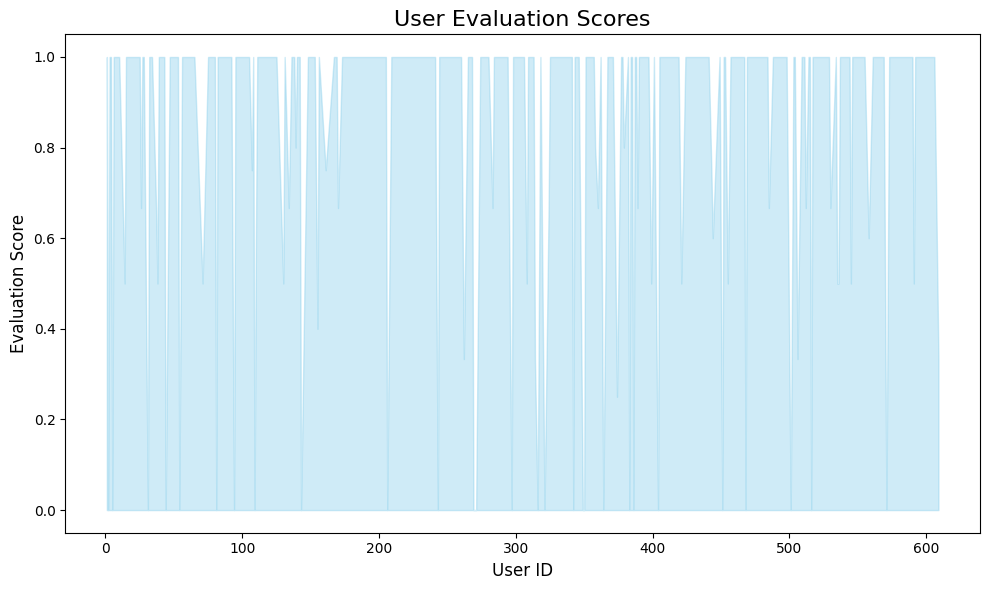

time: 375 ms (started: 2024-05-09 19:40:08 +00:00)


In [ ]:
import matplotlib.pyplot as plt

# Sample data (replace with your actual data)


# Plotting the area chart
plt.figure(figsize=(10, 6))  # Set the figure size (width, height)

# Plotting the area chart
plt.fill_between(user_use, evaluation_scores, color='skyblue', alpha=0.4)  # Fill area under the line

plt.title('User Evaluation Scores', fontsize=16)  # Set the plot title
plt.xlabel('User ID', fontsize=12)  # Set the label for x-axis
plt.ylabel('Evaluation Score', fontsize=12)  # Set the label for y-axis

plt.tight_layout()
plt.show()

In [ ]:
np.mean(evaluation_scores)

0.8609109109109108

time: 7.91 ms (started: 2024-05-09 19:40:08 +00:00)


Overall this experiment seem to give the best results, however, getting the best number of clusters is a time consuming process